In [1]:
#Importing all necessary Libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
stemmer = PorterStemmer()
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from keras import callbacks
from keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional,Embedding
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers

In [2]:
# Reading the data
df=pd.read_csv("E:\\Papers\\Sentiment Analysis\\Coronavirus_Tweets.csv",encoding='latin-1')
print(df.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


In [3]:
# Converting our dataset in DataFrame with two attributes
dataset=pd.DataFrame(df,columns=['OriginalTweet','Sentiment'])
dataset.head(9)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive
7,Was at the supermarket today. Didn't buy toile...,Neutral
8,Due to COVID-19 our retail store and classroom...,Positive


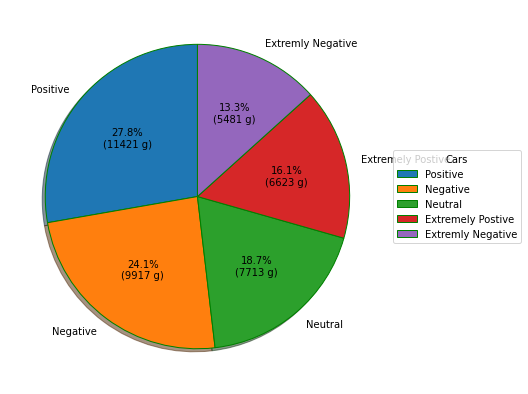

In [4]:
count=dataset["Sentiment"].value_counts()
labels=["Positive","Negative","Neutral","Extremely Postive","Extremly Negative"]
# plt.pie(count,labels=labels)
# plt.legend(["0","1","2","3","4"],labels)
# plt.show()
wp = { 'linewidth' : 1, 'edgecolor' : "green" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(count,autopct = lambda pct: func(pct, count),labels = labels,shadow = True,startangle = 90,wedgeprops = wp)
 
# Adding legend
ax.legend(wedges, labels,title ="Cars",loc ="center left",bbox_to_anchor =(1, 0, 0.5, 1))


In [5]:
# # Creating a function to remove the pattern(@gmail.com)
# def remove_pattern(input_txt, pattern):
#     r = re.findall(pattern, input_txt)
#     for i in r:
#         input_txt = re.sub(i,'',input_txt)
#     return input_txt
# # Create new column with removed @user
# df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')
# df.head()

In [6]:
# # Removing the links from the tweets
# df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
# df['Tweet'].head()

In [7]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
# Replacing/Removing the hashtags from the tweets
def remove_pattern(tweet):
    max_len=0
    r=[]
    for i in tweet:
        k=[]
        for j in i.split(" "):
            t=re.sub("(#.*)|(@.*)|(https.*)"," ",str(j))
            k.append(t)
        max_len=np.max([max_len,len(k)])
        e=' '.join(k)
        r.append(e)
    return [r,max_len]

In [9]:
df['Tweet'],max_len=remove_pattern(df["OriginalTweet"])

In [10]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the ou..."


In [11]:
max_len

127

In [12]:
df['Tweet'].head()

0                                          and   and  
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the   ou...
Name: Tweet, dtype: object

In [13]:
# Removing all words which have length less than 3
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk your neighbours family exchange ph...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths give elderly...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock not the only one which empty... PLE...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready supermarket during the outbreak. Not..."


In [14]:
# Converting the tweets comments in array by splitting them
df['Tweet'] = df['Tweet'].apply(lambda x: x.split())
df['Tweet'].head()

0                                           [and, and]
1    [advice, Talk, your, neighbours, family, excha...
2    [Coronavirus, Australia:, Woolworths, give, el...
3    [food, stock, not, the, only, one, which, empt...
4    [Me,, ready, supermarket, during, the, outbrea...
Name: Tweet, dtype: object

In [15]:
# Converting all the words to their root words Eg:runner,running-->run
df['Tweet'] = df['Tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"[and, and]"
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,"[advic, talk, your, neighbour, famili, exchang..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronaviru, australia:, woolworth, give, elde..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,"[food, stock, not, the, onli, one, which, empt..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[me,, readi, supermarket, dure, the, outbreak...."


In [16]:
# Again Joining the Tweets
for i in range(len(df['Tweet'])):
    df['Tweet'][i] = ' '.join(df['Tweet'][i])
df.head()

C:\Users\welcome\AppData\Local\Temp\ipykernel_2644\2641567938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet'][i] = ' '.join(df['Tweet'][i])


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advic talk your neighbour famili exchang phone...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,"coronaviru australia: woolworth give elderly, ..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock not the onli one which empty... ple...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"me, readi supermarket dure the outbreak. not b..."


In [17]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# from nltk.corpus import stopwords(which does not add meaning to sentance like and,is the)
stop=stopwords.words('english')

# Removing all the stop words from tweets and store it in stopword_x
stopword_x=df['Tweet'].apply(lambda x: [item for item in x if item not in stop])
stopword_x.head()

0                                            [n,  , n]
1    [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, ...
2    [c, r, n, v, r, u,  , u, r, l, :,  , w, l, w, ...
3    [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e, ...
4    [e, ,,  , r, e,  , u, p, e, r, r, k, e,  , u, ...
Name: Tweet, dtype: object

In [19]:
# Considered only two atrributes preprocessed Tweets and sentiment and save it in cdf
cdf=df[['Tweet','Sentiment']]
cdf.head()

,Tweet,Sentiment
0,and and,Neutral
1,advic talk your neighbour famili exchang phone...,Positive
2,"coronaviru australia: woolworth give elderly, ...",Positive
3,food stock not the onli one which empty... ple...,Positive
4,"me, readi supermarket dure the outbreak. not b...",Extremely Negative


In [20]:
t=cdf.iloc[0:5,:1]
max=0
for i in t.values:
    print(i)
    c=len(i)
    if(c>max):
        max=c
print(max)

['and and']
['advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order']
['coronaviru australia: woolworth give elderly, disabl dedic shop hour amid covid-19 outbreak']
["food stock not the onli one which empty... please, don't panic, there will enough food for everyon you not take more than you need. stay calm, stay safe."]
["me, readi supermarket dure the outbreak. not becaus i'm paranoid, but becaus food stock litterali empty. the seriou thing, but please, don't panic. caus shortage..."]
1


In [21]:
# Being sure that we do not have null values
cdf.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [32]:
max_words=41157
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(cdf['Tweet'])
sequ = tokenizer.texts_to_sequences(cdf['Tweet'])
tweets = pad_sequences(sequ, maxlen=max_len)
print(tweets)


[[    0     0     0 ...     0     2     2]
 [    0     0     0 ...    23    95   135]
 [    0     0     0 ...     5     8   118]
 ...
 [    0     0     0 ... 33950    47    27]
 [    0     0     0 ...   181   449   543]
 [    0     0     0 ...     8     6 12560]]


In [33]:
encode=LabelEncoder()
label=encode.fit_transform(cdf['Sentiment'])
print(label)

[3 4 4 ... 4 3 2]


In [34]:
x_train,x_test,y_train,y_test=train_test_split(tweets,label,test_size=0.2)

In [35]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(32925, 127) (8232, 127) (32925,) (8232,)


In [36]:
def plot_ConfusionMatrix(y_pred,y_true):
    disp = ConfusionMatrixDisplay.from_predictions(
                  y_pred, 
                  y_true, 
                  labels=encode.classes_,
                  cmap=plt.cm.Blues,
                  display_labels=encode.classes_, 
                  values_format='',  
    ) 
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(10)
    fig.set_figheight(10) 

In [41]:
def Bilstm_model():
  model=Sequential()
  model.add(Embedding(41157,127))
  model.add(Bidirectional(LSTM(45,activation='relu')))
  # model.add(Bidirectional(LSTM(20,dropout=0.8,activation='relu')))
  model.add(Dense(5,activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
  model.fit(x_train,y_train,epochs=20,batch_size=64)

  model.summary()
  
  pred = np.argmax(model.predict(x_test),axis=1)
  accuracy=accuracy_score(pred,y_test)
  report=classification_report(y_test,pred)
  print("Classification Report= /n",report)
  print("Accuracy of Bidirectional LSTM model--------> ",accuracy)
  # plot_ConfusionMatrix(pred,y_test)
  return model

In [42]:
model=Bilstm_model()

Epoch 1/20
515/515 [==============================] - 83s 146ms/step - loss: 50091536.0000 - accuracy: 0.2783
Epoch 2/20
515/515 [==============================] - 78s 152ms/step - loss: 1.4906 - accuracy: 0.3450
Epoch 3/20
515/515 [==============================] - 77s 149ms/step - loss: 1.3274 - accuracy: 0.4519
Epoch 4/20
515/515 [==============================] - 73s 142ms/step - loss: 1.1747 - accuracy: 0.5391
Epoch 5/20
515/515 [==============================] - 74s 143ms/step - loss: 1.0015 - accuracy: 0.6019
Epoch 6/20
515/515 [==============================] - 75s 145ms/step - loss: 0.8096 - accuracy: 0.6891
Epoch 7/20
515/515 [==============================] - 75s 145ms/step - loss: 0.6647 - accuracy: 0.7551
Epoch 8/20
515/515 [==============================] - 75s 146ms/step - loss: 0.5626 - accuracy: 0.7964
Epoch 9/20
515/515 [==============================] - 75s 146ms/step - loss: 0.4639 - accuracy: 0.8387
Epoch 10/20
515/515 [==============================] - 79s 153ms/s